# Kijkcijfers Project
Naam: Jens Demeyer

Studentennummer: 202398958 

Vak: Machine Learning

Datum: 31/05/2025

## Deel 1: Scrapen van data

curl request om te testen of api werkt en om te kijken in welk formaat de json staat

In [18]:
import requests
from datetime import datetime
import json

# Stap 1: Bouw de API URL met huidige datum
vandaag = 20180127
api_url = f"https://api.cim.be/api/cim_tv_public_results_daily_views?dateDiff={vandaag}&reportType=north"

# Stap 2: Haal data op
try:
    response = requests.get(api_url)
    
    if response.status_code == 200:
        # Stap 3: Parse de JSON data
        data = response.json()
        print("data:", data)
        
    else:
        print(f"Fout bij het ophalen van de gegevens: {response.status_code}")
except requests.exceptions.RequestException as e:
    print(f"Fout bij het ophalen van de gegevens: {e}")

    response_json = json.dumps(data, indent=4)

with open('data.json', 'w') as file:
    json.dump(data, file, indent=4)

data: {'@context': '/api/contexts/CimTvPublicResultsDailyView', '@id': '/api/cim_tv_public_results_daily_views', '@type': 'hydra:Collection', 'hydra:member': [{'@id': '/api/cim_tv_public_results_daily_views/44150', '@type': 'CimTvPublicResultsDailyView', 'id': 44150, 'reportType': 'north', 'dateImport': '2018-01-29T00:00:00.000000', 'dateResult': '2018-01-27T00:00:00.000000', 'ranking': '1', 'description': 'HET 7 UUR-JOURNAAL', 'category': None, 'channel': 'EEN', 'dateDiff': '2018-01-27T00:00:00.000000', 'startTime': '19:00:04', 'rLength': '00:31:57', 'ratePerc': None, 'rateInK': '803.889', 'shr': None, 'rateInKAll': None, 'live': 0}, {'@id': '/api/cim_tv_public_results_daily_views/44151', '@type': 'CimTvPublicResultsDailyView', 'id': 44151, 'reportType': 'north', 'dateImport': '2018-01-29T00:00:00.000000', 'dateResult': '2018-01-27T00:00:00.000000', 'ranking': '2', 'description': 'FC DE KAMPIOENEN', 'category': None, 'channel': 'EEN', 'dateDiff': '2018-01-27T00:00:00.000000', 'startTi

In [25]:
import requests
import csv
from datetime import datetime

def get_viewership_data(date_yyyymmdd):
    api_url = f"https://api.cim.be/api/cim_tv_public_results_daily_views?dateDiff={date_yyyymmdd}&reportType=north"
    
    try:
        response = requests.get(api_url)
        if response.status_code == 200:
            data = response.json()
            return data.get('hydra:member', [])
        else:
            print(f"Fout bij ophalen data voor {date_yyyymmdd}: HTTP {response.status_code}")
            return []
    except requests.exceptions.RequestException as e:
        print(f"Fout bij ophalen data voor {date_yyyymmdd}: {e}")
        return []

def save_to_csv(data, filename='kijkcijfers.csv'):
    if not data:
        print("Geen data om op te slaan")
        return
    
    # Selecteer alleen de gewenste velden
    selected_fields = ['dateDiff', 'ranking', 'description', 'channel', 'startTime', 'rLength', 'rateInK']
    
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=selected_fields)
        writer.writeheader()
        
        for item in data:
            # Maak een nieuw dict met alleen de gewenste velden
            row = {field: item.get(field) for field in selected_fields}
            
            # Formatteer dateDiff naar YYYY-MM-DD
            if 'dateDiff' in row and row['dateDiff']:
                try:
                    dt = datetime.strptime(row['dateDiff'], '%Y-%m-%dT%H:%M:%S.%fZ')
                    row['dateDiff'] = dt.strftime('%Y-%m-%d')
                except ValueError:
                    pass
            
            writer.writerow(row)
    
    print(f"Data opgeslagen in {filename} ({len(data)} records)")

date_str = '20250518'  # Format: YYYYMMDD
data = get_viewership_data(date_str)

if data:
    save_to_csv(data)
else:
    print("Geen data gevonden voor deze datum")

Data opgeslagen in kijkcijfers.csv (20 records)


In [6]:
import requests
import csv
from datetime import datetime, timedelta
import time
from tqdm import tqdm
import os

def get_viewership_data(date_yyyymmdd, max_retries=3):
    """Haal kijkcijferdata op voor specifieke datum"""
    api_url = f"https://api.cim.be/api/cim_tv_public_results_daily_views?dateDiff={date_yyyymmdd}&reportType=north"
    
    for attempt in range(max_retries):
        try:
            response = requests.get(api_url, timeout=30)
            if response.status_code == 200:
                return response.json().get('hydra:member', [])
            return []
        except Exception as e:
            if attempt == max_retries - 1:
                print(f"\nFout voor {date_yyyymmdd}: {str(e)[:100]}...")
            time.sleep(2 ** attempt)
    return []

def append_to_csv(data, filename='kijkcijfers.csv'):
    """Voeg data toe aan CSV zonder duplicate checking"""
    if not data:
        return
    
    fields = ['dateDiff', 'ranking', 'description', 'channel', 'startTime', 'rLength', 'rateInK']
    file_exists = os.path.isfile(filename)
    
    with open(filename, 'a', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fields)
        if not file_exists:
            writer.writeheader()
        
        for item in data:
            row = {field: item.get(field) for field in fields}
            if 'dateDiff' in row and row['dateDiff']:
                try:
                    dt = datetime.strptime(row['dateDiff'], '%Y-%m-%dT%H:%M:%S.%fZ')
                    row['dateDiff'] = dt.strftime('%Y-%m-%d')
                except ValueError:
                    pass
            writer.writerow(row)

def scrape_with_progress(start_date, end_date):
    """Scrape data voor een periode met voortgangsbalk"""
    date_range = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]
    
    with tqdm(total=len(date_range), desc="Data scrapen", unit="dag") as pbar:
        for date in date_range:
            date_str = date.strftime('%Y%m%d')
            data = get_viewership_data(date_str)
            append_to_csv(data)
            pbar.update(1)
            time.sleep(0.5)  # Mild rate limiting

    print(f"\nData succesvol toegevoegd aan kijkcijfers.csv")

# Voorbeeldgebruik:
if __name__ == "__main__":
    scrape_with_progress(
        start_date=datetime(2019, 11, 1),
        end_date=datetime(2025, 5, 20)
    )

Data scrapen: 100%|██████████| 2028/2028 [29:59<00:00,  1.13dag/s]  


Data succesvol toegevoegd aan kijkcijfers.csv


In [11]:
import csv
from datetime import datetime

def clean_holidays_file(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as infile, \
         open(output_file, 'w', newline='', encoding='utf-8') as outfile:
        
        reader = csv.DictReader(infile, delimiter=';')
        writer = csv.DictWriter(outfile, fieldnames=['date', 'holiday_name'], delimiter=';')
        writer.writeheader()
        
        for row in reader:
            # Pak alleen de NL naam (alles tussen "NL " en de volgende komma)
            name_nl = row['Name'].split('NL ')[1].split(',')[0].strip()
            
            # Schrijf alleen de gewenste velden
            writer.writerow({
                'date': row['StartDate'],
                'holiday_name': name_nl
            })

# Pas aan voor jouw bestandsnamen
clean_holidays_file('holidays.public.csv', 'holidays_clean.csv')

In [42]:
import csv

def clean_school_holidays(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as infile, \
         open(output_file, 'w', newline='', encoding='utf-8') as outfile:
        
        reader = csv.DictReader(infile, delimiter=';')
        writer = csv.DictWriter(outfile, fieldnames=['start_date', 'end_date', 'holiday_name'], delimiter=';')
        writer.writeheader()
        
        for row in reader:
            # Pak alleen de NL naam (alles tussen "NL " en de volgende komma)
            name_nl = row['Name'].split('NL ')[1].split(',')[0].strip()
            
            # Schrijf alleen de gewenste velden
            writer.writerow({
                'start_date': row['StartDate'],
                'end_date': row['EndDate'],
                'holiday_name': name_nl
            })

# Pas aan voor jouw bestandsnamen
clean_school_holidays('Data/InputData/holidays.school.vlaanderen.csv', './Data/CleanData/school_holidays_clean.csv')


Later heb ik manueel de data voor 2016-2019 toegevoegd

In [5]:
import pandas as pd
from datetime import datetime

# Laad de hoofddata
df_main = pd.read_csv('./Data/CleanData/kijkcijfers.csv', delimiter=',')

# Laad de feestdagen data
df_holidays = pd.read_csv('./Data/CleanData/holidays_clean.csv', delimiter=';')
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

# Laad de schoolvakanties data
df_school_holidays = pd.read_csv('./Data/CleanData/school_holidays_clean.csv', delimiter=';')
df_school_holidays['start_date'] = pd.to_datetime(df_school_holidays['start_date'])
df_school_holidays['end_date'] = pd.to_datetime(df_school_holidays['end_date'])

# Converteer dateDiff naar datetime
df_main['dateDiff'] = pd.to_datetime(df_main['dateDiff'])

# Maak is_holiday feature
def check_holiday(date):
    # Check publieke feestdagen
    if date in df_holidays['date'].values:
        return 1
    
    # Check schoolvakanties
    for _, row in df_school_holidays.iterrows():
        if row['start_date'] <= date <= row['end_date']:
            return 1
    
    return 0

df_main['is_holiday'] = df_main['dateDiff'].apply(check_holiday)

print(df_main.head())

print(df_main[df_main['dateDiff'] == pd.to_datetime('2016-11-01')].head())


    dateDiff  ranking         description channel startTime   rLength  \
0 2016-10-01        4    IEDEREEN BEROEMD     EEN  19:38:10  00:29:01   
1 2016-10-01        5      COMEDY TOPPERS     VTM  19:52:06  00:24:40   
2 2016-10-01        6        THE FUGITIVE     EEN  21:22:25  02:01:25   
3 2016-10-01        7      NIEUWS 19U VTM     VTM  18:59:49  00:42:27   
4 2016-10-01        8  HET 1 UUR-JOURNAAL     EEN  13:00:05  00:22:48   

   rateInK  is_holiday  
0  523.610           0  
1  496.216           0  
2  447.427           0  
3  424.041           0  
4  369.066           0  
      dateDiff  ranking                 description channel startTime  \
601 2016-11-01        1                       THUIS     EEN  20:15:47   
602 2016-11-01        2          HET 7 UUR-JOURNAAL     EEN  19:00:04   
603 2016-11-01        3            IEDEREEN BEROEMD     EEN  19:46:21   
604 2016-11-01        4  DE SLIMSTE MENS TER WERELD    VIER  21:34:44   
605 2016-11-01        5                     FA

In [4]:
import pandas as pd
import numpy as np
import re
from datetime import datetime

def load_and_prepare_data(
    kijkcijfers_path='./Data/CleanData/kijkcijfers.csv',
    holidays_path='./Data/CleanData/holidays_clean.csv',
    school_holidays_path='./Data/CleanData/school_holidays_clean.csv'
):
    # 1. Laad data
    df_main = pd.read_csv(kijkcijfers_path, delimiter=',')
    df_holidays = pd.read_csv(holidays_path, delimiter=';')
    df_holidays['date'] = pd.to_datetime(df_holidays['date'])
    df_school_holidays = pd.read_csv(school_holidays_path, delimiter=';')
    df_school_holidays['start_date'] = pd.to_datetime(df_school_holidays['start_date'])
    df_school_holidays['end_date'] = pd.to_datetime(df_school_holidays['end_date'])

    # 2. Datum conversies
    df_main['dateDiff'] = pd.to_datetime(df_main['dateDiff'])

    # 3. Feestdag feature
    def check_holiday(date):
        if date in df_holidays['date'].values:
            return 1
        for _, row in df_school_holidays.iterrows():
            if row['start_date'] <= date <= row['end_date']:
                return 1
        return 0
    df_main['is_holiday'] = df_main['dateDiff'].apply(check_holiday)

    # 4. Weekdag, maand
    df_main['weekday'] = df_main['dateDiff'].dt.dayofweek
    df_main['month'] = df_main['dateDiff'].dt.month

    # 5. Starttijd fixen en primetime/weekend features
    def fix_invalid_time(t):
        if isinstance(t, str) and t.startswith("24:"):
            return "00:" + t[3:]
        return t
    df_main['startTime_fixed'] = df_main['startTime'].apply(fix_invalid_time)
    df_main['startTime'] = pd.to_datetime(df_main['startTime_fixed'], format='%H:%M:%S', errors='coerce').dt.time

    primetime_start = pd.to_datetime('18:30:00').time()
    primetime_end = pd.to_datetime('22:00:00').time()
    df_main['is_primetime'] = df_main['startTime'].apply(
        lambda x: 1 if pd.notnull(x) and primetime_start <= x <= primetime_end else 0
    )
    df_main['is_weekend'] = df_main['weekday'].apply(lambda x: 1 if x >= 5 else 0)

    # 6. Nieuws/sport features
    news_keywords = ['journaal', 'nieuws', 'sportweekend']
    sports_keywords = [
        'voetbal', 'wielrennen', 'veldrijden','golf', 'boxen','snooker', 'tennis','atletiek', 'zwemmen',
        'volleybal', 'basketbal', 'handbal', 'hockey', 'formule 1', 'f1', 'vb', 'o.s.', 'darts'
    ]
    news_pattern = re.compile('|'.join(news_keywords), flags=re.IGNORECASE)
    # sports_pattern = re.compile('|'.join(sports_keywords), flags=re.IGNORECASE)
    df_main['is_news'] = df_main['description'].apply(lambda x: 1 if news_pattern.search(str(x)) else 0)
    # df_main['is_sports'] = df_main['description'].apply(lambda x: 1 if sports_pattern.search(str(x)) else 0)

    # 7. Duur in minuten en film-feature
    df_main['duration_min'] = round(pd.to_timedelta(df_main['rLength']).dt.total_seconds() / 60, 2)
    # df_main['is_film'] = (df_main['duration_min'] > 95).astype(int)
    # df_main.loc[df_main['is_sports'] == 1, 'is_film'] = 0

    # 8. Kijkcijfers fixen (punt als duizendtalscheiding)
    df_main.rename(columns={'rateInK': 'aantal_kijkers'}, inplace=True)
    df_main['aantal_kijkers'] = df_main['aantal_kijkers'].astype(str).str.replace('.', '', regex=False)
    df_main['aantal_kijkers'] = pd.to_numeric(df_main['aantal_kijkers'], errors='coerce').astype('Int64')

    # 9. Uur-kolom en minuten sinds middernacht
    df_main['hour'] = pd.to_datetime(df_main['startTime_fixed'], format='%H:%M:%S', errors='coerce').dt.hour
    
    # Nieuwe feature: minuten sinds middernacht
    def time_to_minutes(time_str):
        try:
            h, m, s = map(int, time_str.split(':'))
            return h * 60 + m
        except:
            return np.nan
    df_main['minutes_since_midnight'] = df_main['startTime_fixed'].apply(time_to_minutes)

    # 10. Selecteer kolommen (zonder description en startTime_fixed, met minutes_since_midnight)
    desired_columns = [
        'channel', 'minutes_since_midnight', 'duration_min', 'weekday', 'month', 'hour',
        'aantal_kijkers', 'is_primetime', 'is_weekend', 'is_holiday', 'is_news',
    ]
    df_final = df_main[desired_columns]

    # 11. Outliers verwijderen op aantal_kijkers
    Q1 = df_final['aantal_kijkers'].quantile(0.25)
    Q3 = df_final['aantal_kijkers'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_final = df_final[(df_final['aantal_kijkers'] >= lower_bound) & (df_final['aantal_kijkers'] <= upper_bound)]

    # 12. Verwijder records zonder geldige tijd
    df_final = df_final[df_final['hour'].notnull()].reset_index(drop=True)

    return df_final

# Gebruik de pipeline:
df = load_and_prepare_data()
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   channel                 62096 non-null  object 
 1   minutes_since_midnight  62096 non-null  float64
 2   duration_min            62096 non-null  float64
 3   weekday                 62096 non-null  int32  
 4   month                   62096 non-null  int32  
 5   hour                    62096 non-null  float64
 6   aantal_kijkers          62096 non-null  Int64  
 7   is_primetime            62096 non-null  int64  
 8   is_weekend              62096 non-null  int64  
 9   is_holiday              62096 non-null  int64  
 10  is_news                 62096 non-null  int64  
dtypes: Int64(1), float64(3), int32(2), int64(4), object(1)
memory usage: 4.8+ MB
None
  channel  minutes_since_midnight  duration_min  weekday  month  hour  \
0     EEN                  1178.0         

In [ ]:
# ...bestaande code...

# 10. Selecteer kolommen (zonder description en startTime_fixed, met minutes_since_midnight)
desired_columns = [
    'channel', 'minutes_since_midnight', 'duration_min', 'weekday', 'month', 'hour',
    'aantal_kijkers', 'is_primetime', 'is_weekend', 'is_holiday', 'is_news',
    # 'is_sports',   # tijdelijk uitgeschakeld
    # 'is_film',     # tijdelijk uitgeschakeld
]
df_final = df_main[desired_columns]

# ...bestaande code...

# Ook bij het selecteren van features voor X:
feature_columns = [
    'channel',         # categorisch
    'minutes_since_midnight',
    'duration_min',
    'weekday',
    'month',
    'hour',
    'is_primetime',
    'is_weekend',
    'is_holiday',
    'is_news',
    # 'is_sports',   # tijdelijk uitgeschakeld
    # 'is_film',     # tijdelijk uitgeschakeld
]

X = df[feature_columns]
y = df['aantal_kijkers']

# ...bestaande code...

In [29]:
import pandas as pd
from datetime import datetime

df_main['weekday'] = df_main['dateDiff'].dt.dayofweek
df_main['month'] = df_main['dateDiff'].dt.month

# 3. Voeg is_primetime toe (18:30-22:00)
# Eerst startTime omzetten naar datetime voor vergelijking
def fix_invalid_time(t):
    # Corrigeer "24:xx:xx" naar "00:xx:xx"
    if isinstance(t, str) and t.startswith("24:"):
        return "00:" + t[3:]
    return t

df_main['startTime_fixed'] = df_main['startTime'].apply(fix_invalid_time)
df_main['startTime'] = pd.to_datetime(df_main['startTime_fixed'], format='%H:%M:%S', errors='coerce').dt.time

# Maak primetime begin en eind
primetime_start = pd.to_datetime('18:30:00').time()
primetime_end = pd.to_datetime('22:00:00').time()

df_main['is_primetime'] = df_main['startTime'].apply(
    lambda x: 1 if pd.notnull(x) and primetime_start <= x <= primetime_end else 0
)

df_main['is_weekend'] = df_main['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Optioneel: Toon resultaat
print(df_main[['dateDiff', 'startTime', 'weekday', 'month', 'is_primetime', 'is_weekend']].head(10))

print(df_main.head())


NameError: name 'df_main' is not defined

In [ ]:
import pandas as pd
import re

# Lijst van nieuwsgerelateerde trefwoorden (kan uitgebreid worden)
news_keywords = [
    'journaal', 'nieuws', 'sportweekend'
]

# Lijst van sportgerelateerde trefwoorden (kan uitgebreid worden)
sports_keywords = [
    'voetbal', 'wielrennen', 'veldrijden','golf', 'boxen','snooker', 'tennis','atletiek', 'zwemmen',
    'volleybal', 'basketbal', 'handbal', 'hockey', 'formule 1', 'f1', 'vb', 'o.s.', 'darts'
]

# Maak regex patronen voor efficiënte matching
news_pattern = re.compile('|'.join(news_keywords), flags=re.IGNORECASE)
sports_pattern = re.compile('|'.join(sports_keywords), flags=re.IGNORECASE)

# Voeg features toe
df_main['is_news'] = df_main['description'].apply(
    lambda x: 1 if news_pattern.search(str(x)) else 0
)

df_main['is_sports'] = df_main['description'].apply(
    lambda x: 1 if sports_pattern.search(str(x)) else 0
)

# Toon resultaten
print("\nAantal nieuwsprogramma's:", df_main['is_news'].sum())
print("Aantal sportprogramma's:", df_main['is_sports'].sum())
print("\nVoorbeeld van geclassificeerde programma's:")
print(df_main[['description', 'is_news', 'is_sports']].sample(10))


Aantal nieuwsprogramma's: 15498
Aantal sportprogramma's: 4038

Voorbeeld van geclassificeerde programma's:
                                          description  is_news  is_sports
2670                                         HYSTERIA        0          0
11377                              HET 1 UUR-JOURNAAL        1          0
47149             VERLIEFD, VERLOOFD, GETROUWD IN 24U        0          0
52942                                         FAMILIE        0          0
28026                              HET 7 UUR-JOURNAAL        1          0
32418  WIELRENNEN. PARIJS-NICE - RIT 6 BRIGNOLES>BIOT        0          1
5440                                PARENTAL GUIDANCE        0          0
45194                         VLAANDEREN VAKANTIELAND        0          0
51058                                           THUIS        0          0
5162                                   NIEUWS 13U VTM        1          0


In [ ]:
# Converteer eerst rLength naar minuten als je dit nog niet gedaan hebt
df_main['duration_min'] = round(pd.to_timedelta(df_main['rLength']).dt.total_seconds() / 60, 2)

# Maak de is_film feature (1 als duration_min > 105, anders 0)
df_main['is_film'] = (df_main['duration_min'] > 95).astype(int)

df_main.loc[df_main['is_sports'] == 1, 'is_film'] = 0

# Voorbeelden tonen
print("\nVoorbeeld van film-classificatie:")
print(df_main[['description', 'rLength', 'duration_min', 'is_film']].sample(10))


Voorbeeld van film-classificatie:
                                      description   rLength  duration_min  \
58861                                SPORTWEEKEND  00:32:35         32.58   
11106                                       THUIS  00:25:23         25.38   
40943  VB. C1 UEFA 1/2F - R. MADRID/MANCHESTER C.  02:17:43        137.72   
56001                                HET CONCLAAF  00:58:50         58.83   
57947                    DE JAREN 80 VOOR TIENERS  00:55:31         55.52   
33098                                        LISA  00:21:54         21.90   
20049                        DAGELIJKSE ZOMERKOST  00:16:55         16.92   
48392                                     FLIKKEN  00:47:14         47.23   
53627                           WAT ZOU JIJ DOEN?  00:55:11         55.18   
9320                         GEUBELS EN DE BELGEN  00:32:30         32.50   

       is_film  
58861        0  
11106        0  
40943        0  
56001        0  
57947        0  
33098        0 

In [ ]:
print(df_main.head())

    dateDiff  ranking         description channel startTime   rLength  \
0 2016-10-01        4    IEDEREEN BEROEMD     EEN  19:38:10  00:29:01   
1 2016-10-01        5      COMEDY TOPPERS     VTM  19:52:06  00:24:40   
2 2016-10-01        6        THE FUGITIVE     EEN  21:22:25  02:01:25   
3 2016-10-01        7      NIEUWS 19U VTM     VTM  18:59:49  00:42:27   
4 2016-10-01        8  HET 1 UUR-JOURNAAL     EEN  13:00:05  00:22:48   

   rateInK  is_holiday  weekday  month startTime_fixed  is_primetime  \
0  523.610           0        5     10        19:38:10             1   
1  496.216           0        5     10        19:52:06             1   
2  447.427           0        5     10        21:22:25             1   
3  424.041           0        5     10        18:59:49             1   
4  369.066           0        5     10        13:00:05             0   

   is_weekend  is_news  is_sports  duration_min  is_film  
0           1        0          0         29.02        0  
1         

In [ ]:
#rateInK veranderen van naam naar aantal_kijkers
df_main.rename(columns={'rateInK': 'aantal_kijkers'}, inplace=True)

# Zet de 'aantal_kijkers' kolom om naar int, waarbij de punt als duizendtalscheiding wordt gezien
df_main['aantal_kijkers'] = df_main['aantal_kijkers'].astype(str).str.replace('.', '', regex=False)
df_main['aantal_kijkers'] = pd.to_numeric(df_main['aantal_kijkers'], errors='coerce').astype('Int64')


# Voeg een kolom 'hour' toe op basis van 'startTime_fixed'
df_main['hour'] = pd.to_datetime(df_main['startTime_fixed'], format='%H:%M:%S', errors='coerce').dt.hour


# Definieer de gewenste kolommen in de juiste volgorde
desired_columns = [
    'description', 
    'channel', 
    'startTime_fixed', 
    'duration_min', 
    'weekday', 
    'month',
    'hour',   
    'aantal_kijkers', 
    'is_primetime', 
    'is_weekend', 
    'is_holiday',
    'is_news', 
    'is_sports', 
    'is_film'
]

# Filter de DataFrame om alleen deze kolommen te behouden
df_final = df_main[desired_columns]

# Toon het resultaat
print(df_final.sample(10))



                                       description channel startTime_fixed  \
59990  BASKET. BNXT LEAGUE H. - CHARLEROI/KORTRIJK   VRT 1        13:36:51   
28349                               NIEUWS 19U VTM     VTM        18:59:44   
18487                             IEDEREEN BEROEMD     EEN        19:46:30   
48520                              EEN JAAR OP ZEE   VRT 1        20:48:29   
41398                            HET JOURNAAL LAAT     EEN        22:32:24   
60138                                        THUIS   VRT 1        20:18:34   
63343                               NIEUWS 19U VTM     VTM        18:59:48   
41950                                      BLOKKEN     EEN        18:30:22   
54142                                      BLOKKEN   VRT 1        18:29:59   
27130                               NIEUWS 19U VTM     VTM        19:00:03   

       duration_min  weekday  month  hour  aantal_kijkers  is_primetime  \
59990         29.60        6     12  13.0          274312         

In [ ]:
df_final.info()

df_final.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63398 entries, 0 to 63397
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   description      63386 non-null  object 
 1   channel          63367 non-null  object 
 2   startTime_fixed  63365 non-null  object 
 3   duration_min     63365 non-null  float64
 4   weekday          63398 non-null  int32  
 5   month            63398 non-null  int32  
 6   hour             63359 non-null  float64
 7   aantal_kijkers   63285 non-null  Int64  
 8   is_primetime     63398 non-null  int64  
 9   is_weekend       63398 non-null  int64  
 10  is_holiday       63398 non-null  int64  
 11  is_news          63398 non-null  int64  
 12  is_sports        63398 non-null  int64  
 13  is_film          63398 non-null  int64  
dtypes: Int64(1), float64(2), int32(2), int64(6), object(3)
memory usage: 6.3+ MB


,duration_min,weekday,month,hour,aantal_kijkers,is_primetime,is_weekend,is_holiday,is_news,is_sports,is_film
count,63365.000000,63398.000000,63398.000000,63359.000000,63285.0,63398.000000,63398.000000,63398.000000,63398.000000,63398.000000,63398.000000
mean,44.707601,3.002177,6.478580,18.610679,444213.649206,0.582258,0.286586,0.296113,0.244456,0.063693,0.036925
std,29.281509,2.001883,3.502318,2.918637,276984.016029,0.493191,0.452170,0.456545,0.429767,0.244207,0.188580
min,15.000000,0.000000,1.000000,0.000000,15887.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.120000,1.000000,3.000000,18.000000,229080.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.370000,3.000000,6.000000,19.000000,358609.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,51.070000,5.000000,10.000000,20.000000,603129.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,589.320000,6.000000,12.000000,23.000000,2494114.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


array([[<Axes: title={'center': 'duration_min'}>,
        <Axes: title={'center': 'weekday'}>,
        <Axes: title={'center': 'month'}>],
       [<Axes: title={'center': 'hour'}>,
        <Axes: title={'center': 'aantal_kijkers'}>,
        <Axes: title={'center': 'is_primetime'}>],
       [<Axes: title={'center': 'is_weekend'}>,
        <Axes: title={'center': 'is_holiday'}>,
        <Axes: title={'center': 'is_news'}>],
       [<Axes: title={'center': 'is_sports'}>,
        <Axes: title={'center': 'is_film'}>, <Axes: >]], dtype=object)

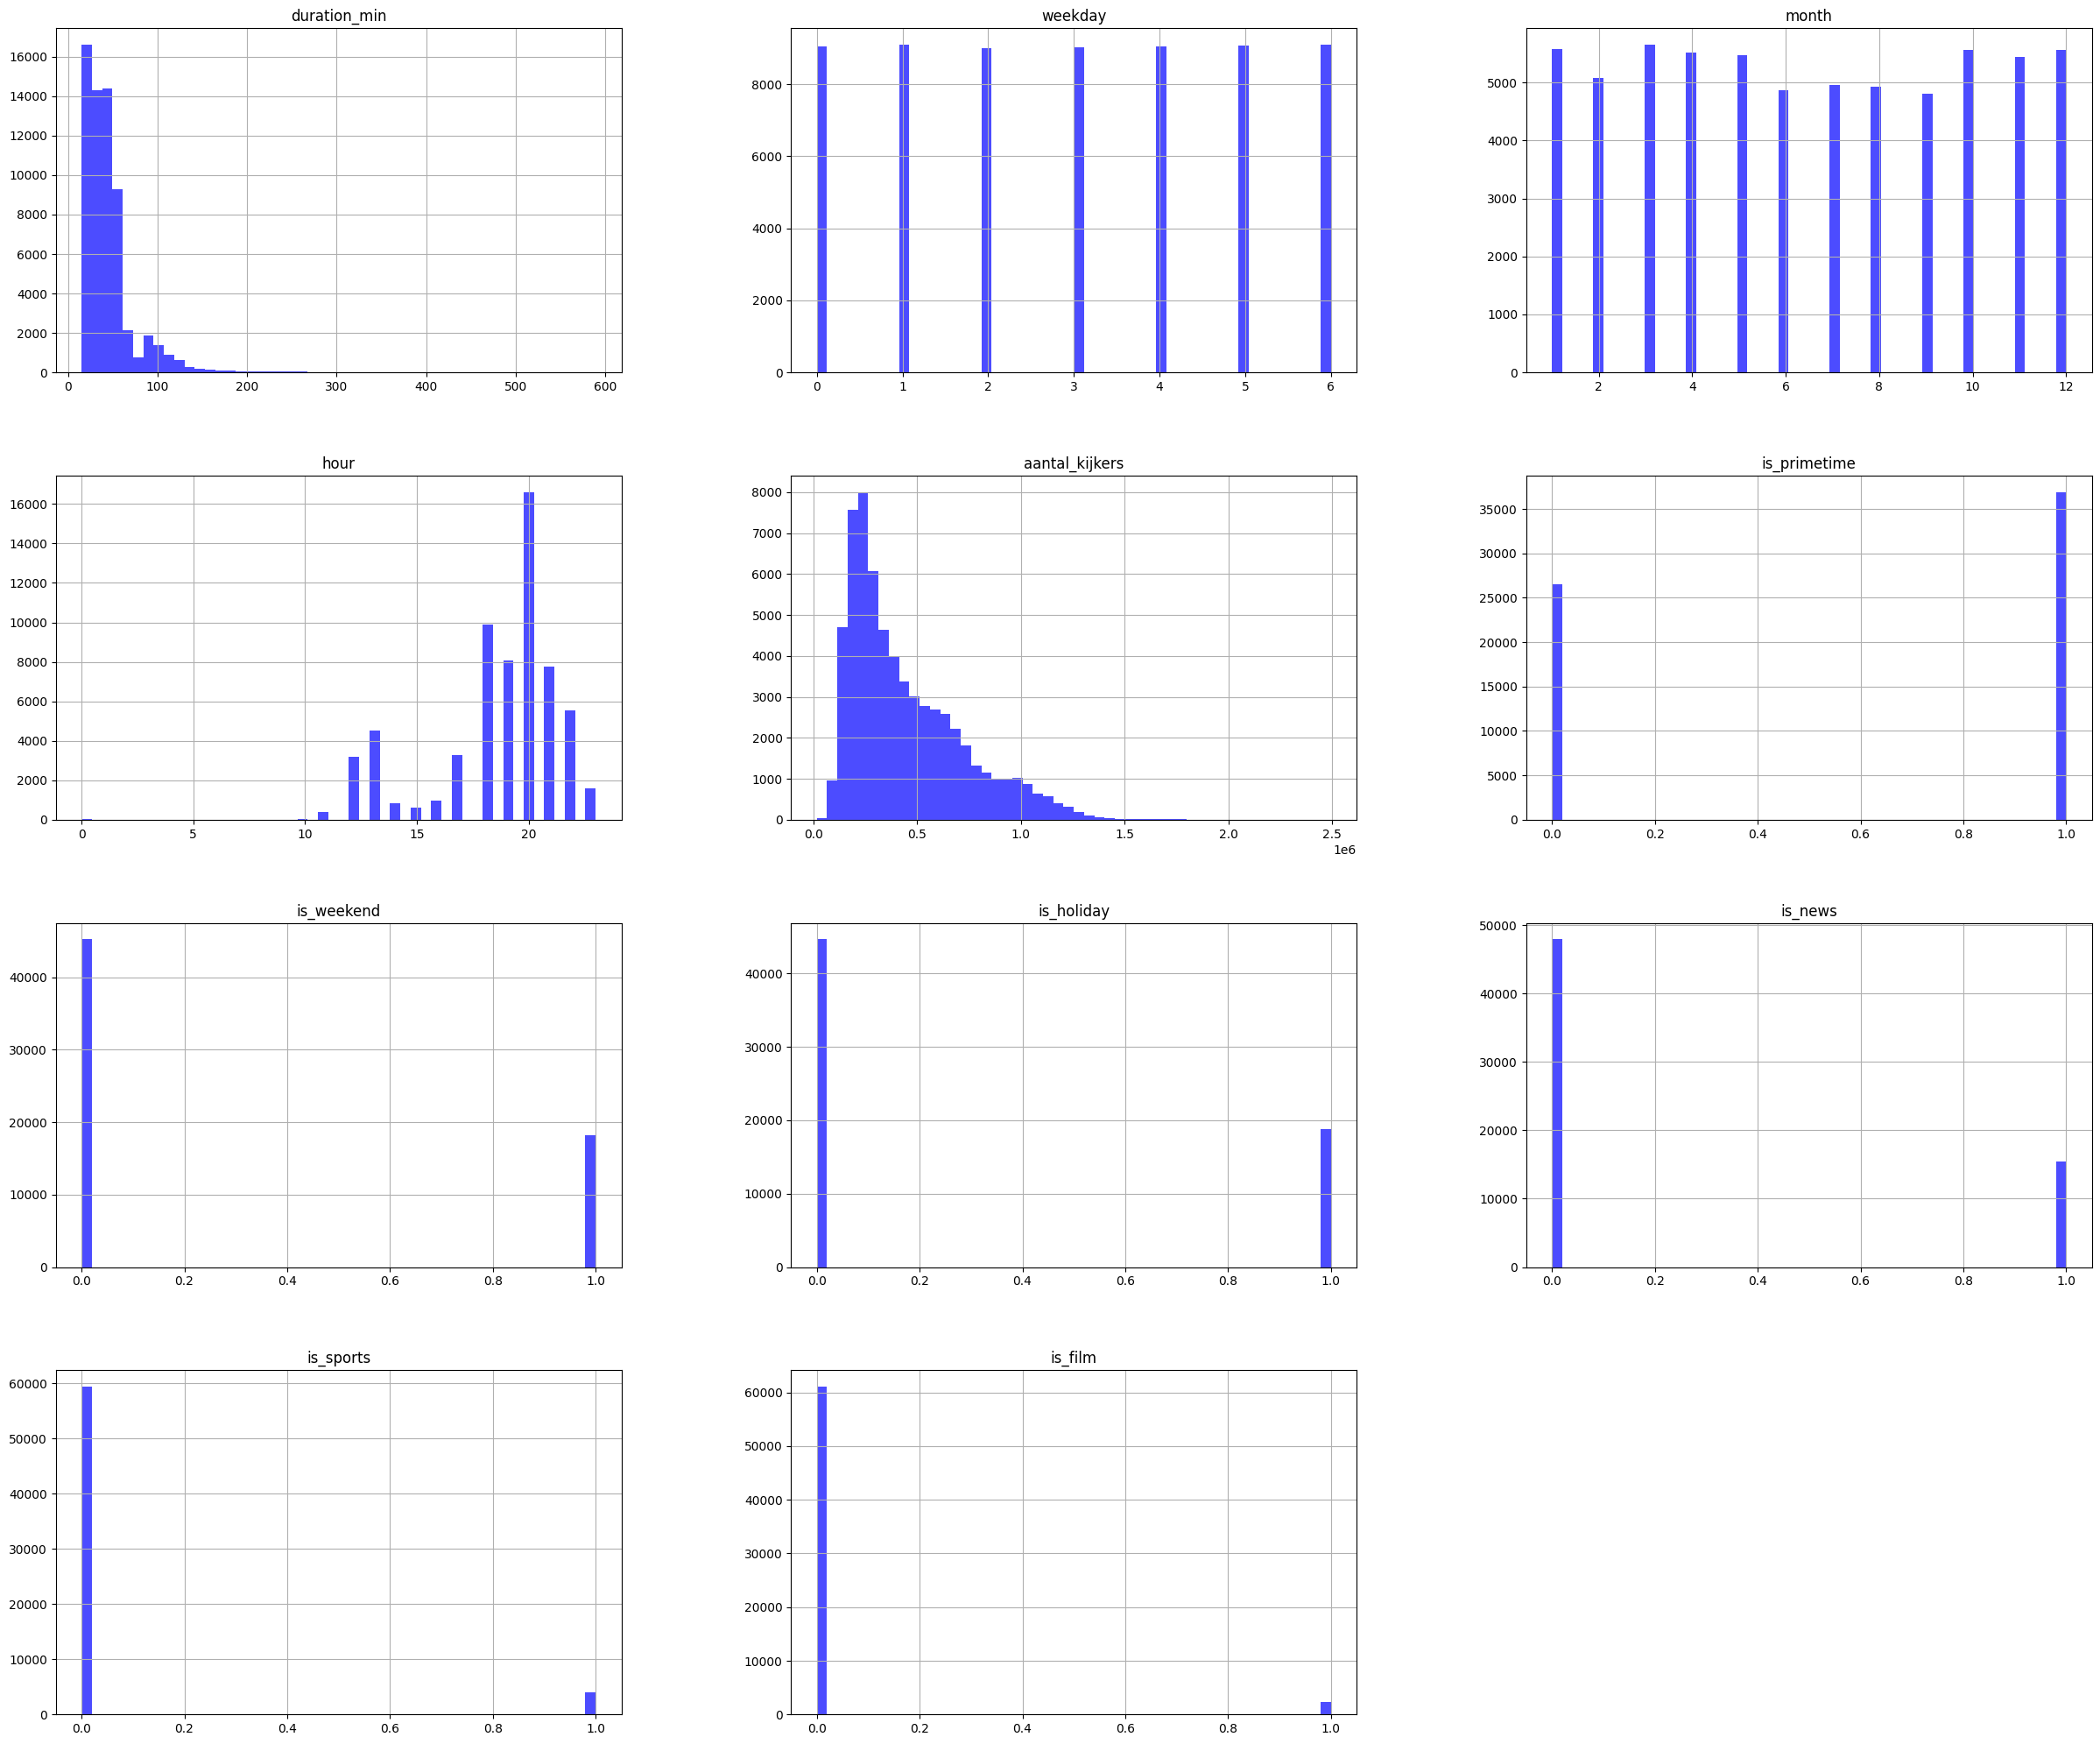

In [ ]:
df_final.hist(bins=50, figsize=(30,25), color='blue', alpha=0.7)


In [ ]:

# Outlier-detectie met de IQR-methode
Q1 = df_final['aantal_kijkers'].quantile(0.25)
Q3 = df_final['aantal_kijkers'].quantile(0.75)
IQR = Q3 - Q1

# Definieer outliers als waarden buiten 1.5 * IQR van Q1 en Q3
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_final[df_final['aantal_kijkers'] > upper_bound]
print(f"Aantal outliers: {len(outliers)}")
print(outliers[['description', 'channel', 'aantal_kijkers']].sort_values('aantal_kijkers', ascending=False))



Aantal outliers: 1183
                             description channel  aantal_kijkers
12906    VB. WK. 1/2F - FRANKRIJK/BELGIE     EEN         2494114
34548     VB. EK. 1/8F - BELGIE/PORTUGAL     EEN         2449938
12826     VB. WK. 1/4F - BRAZILIE/BELGIE     EEN         2221137
12746     VB. WK. SCHIFT. - BELGIE/JAPAN     EEN         2194175
12827              VB. WK. 1/4F - STUDIO     EEN         2178735
...                                  ...     ...             ...
30010         DE SLIMSTE MENS TER WERELD    VIER         1164501
57098  VB. EK. 1/2F - NEDERLAND/ENGELAND   VRT 1         1164485
23106                              THUIS     EEN         1164454
30568                 HET 7 UUR-JOURNAAL     EEN         1164433
4946                               THUIS     EEN         1164264

[1183 rows x 3 columns]


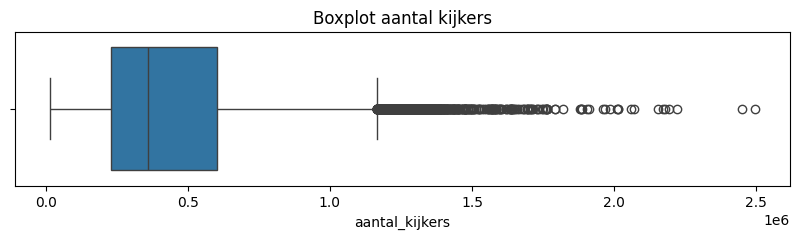

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 2))
sns.boxplot(x=df_final['aantal_kijkers'])
plt.title('Boxplot aantal kijkers')
plt.show()

In [ ]:
df_final_no_outliers_kijkcijfers = df_final[(df_final['aantal_kijkers'] >= lower_bound) & (df_final['aantal_kijkers'] <= upper_bound)]


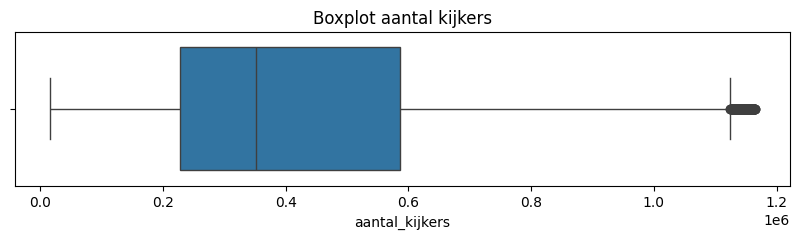

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 2))
sns.boxplot(x=df_final_no_outliers_kijkcijfers['aantal_kijkers'])
plt.title('Boxplot aantal kijkers')
plt.show()

array([[<Axes: title={'center': 'duration_min'}>,
        <Axes: title={'center': 'weekday'}>,
        <Axes: title={'center': 'month'}>],
       [<Axes: title={'center': 'hour'}>,
        <Axes: title={'center': 'aantal_kijkers'}>,
        <Axes: title={'center': 'is_primetime'}>],
       [<Axes: title={'center': 'is_weekend'}>,
        <Axes: title={'center': 'is_holiday'}>,
        <Axes: title={'center': 'is_news'}>],
       [<Axes: title={'center': 'is_sports'}>,
        <Axes: title={'center': 'is_film'}>, <Axes: >]], dtype=object)

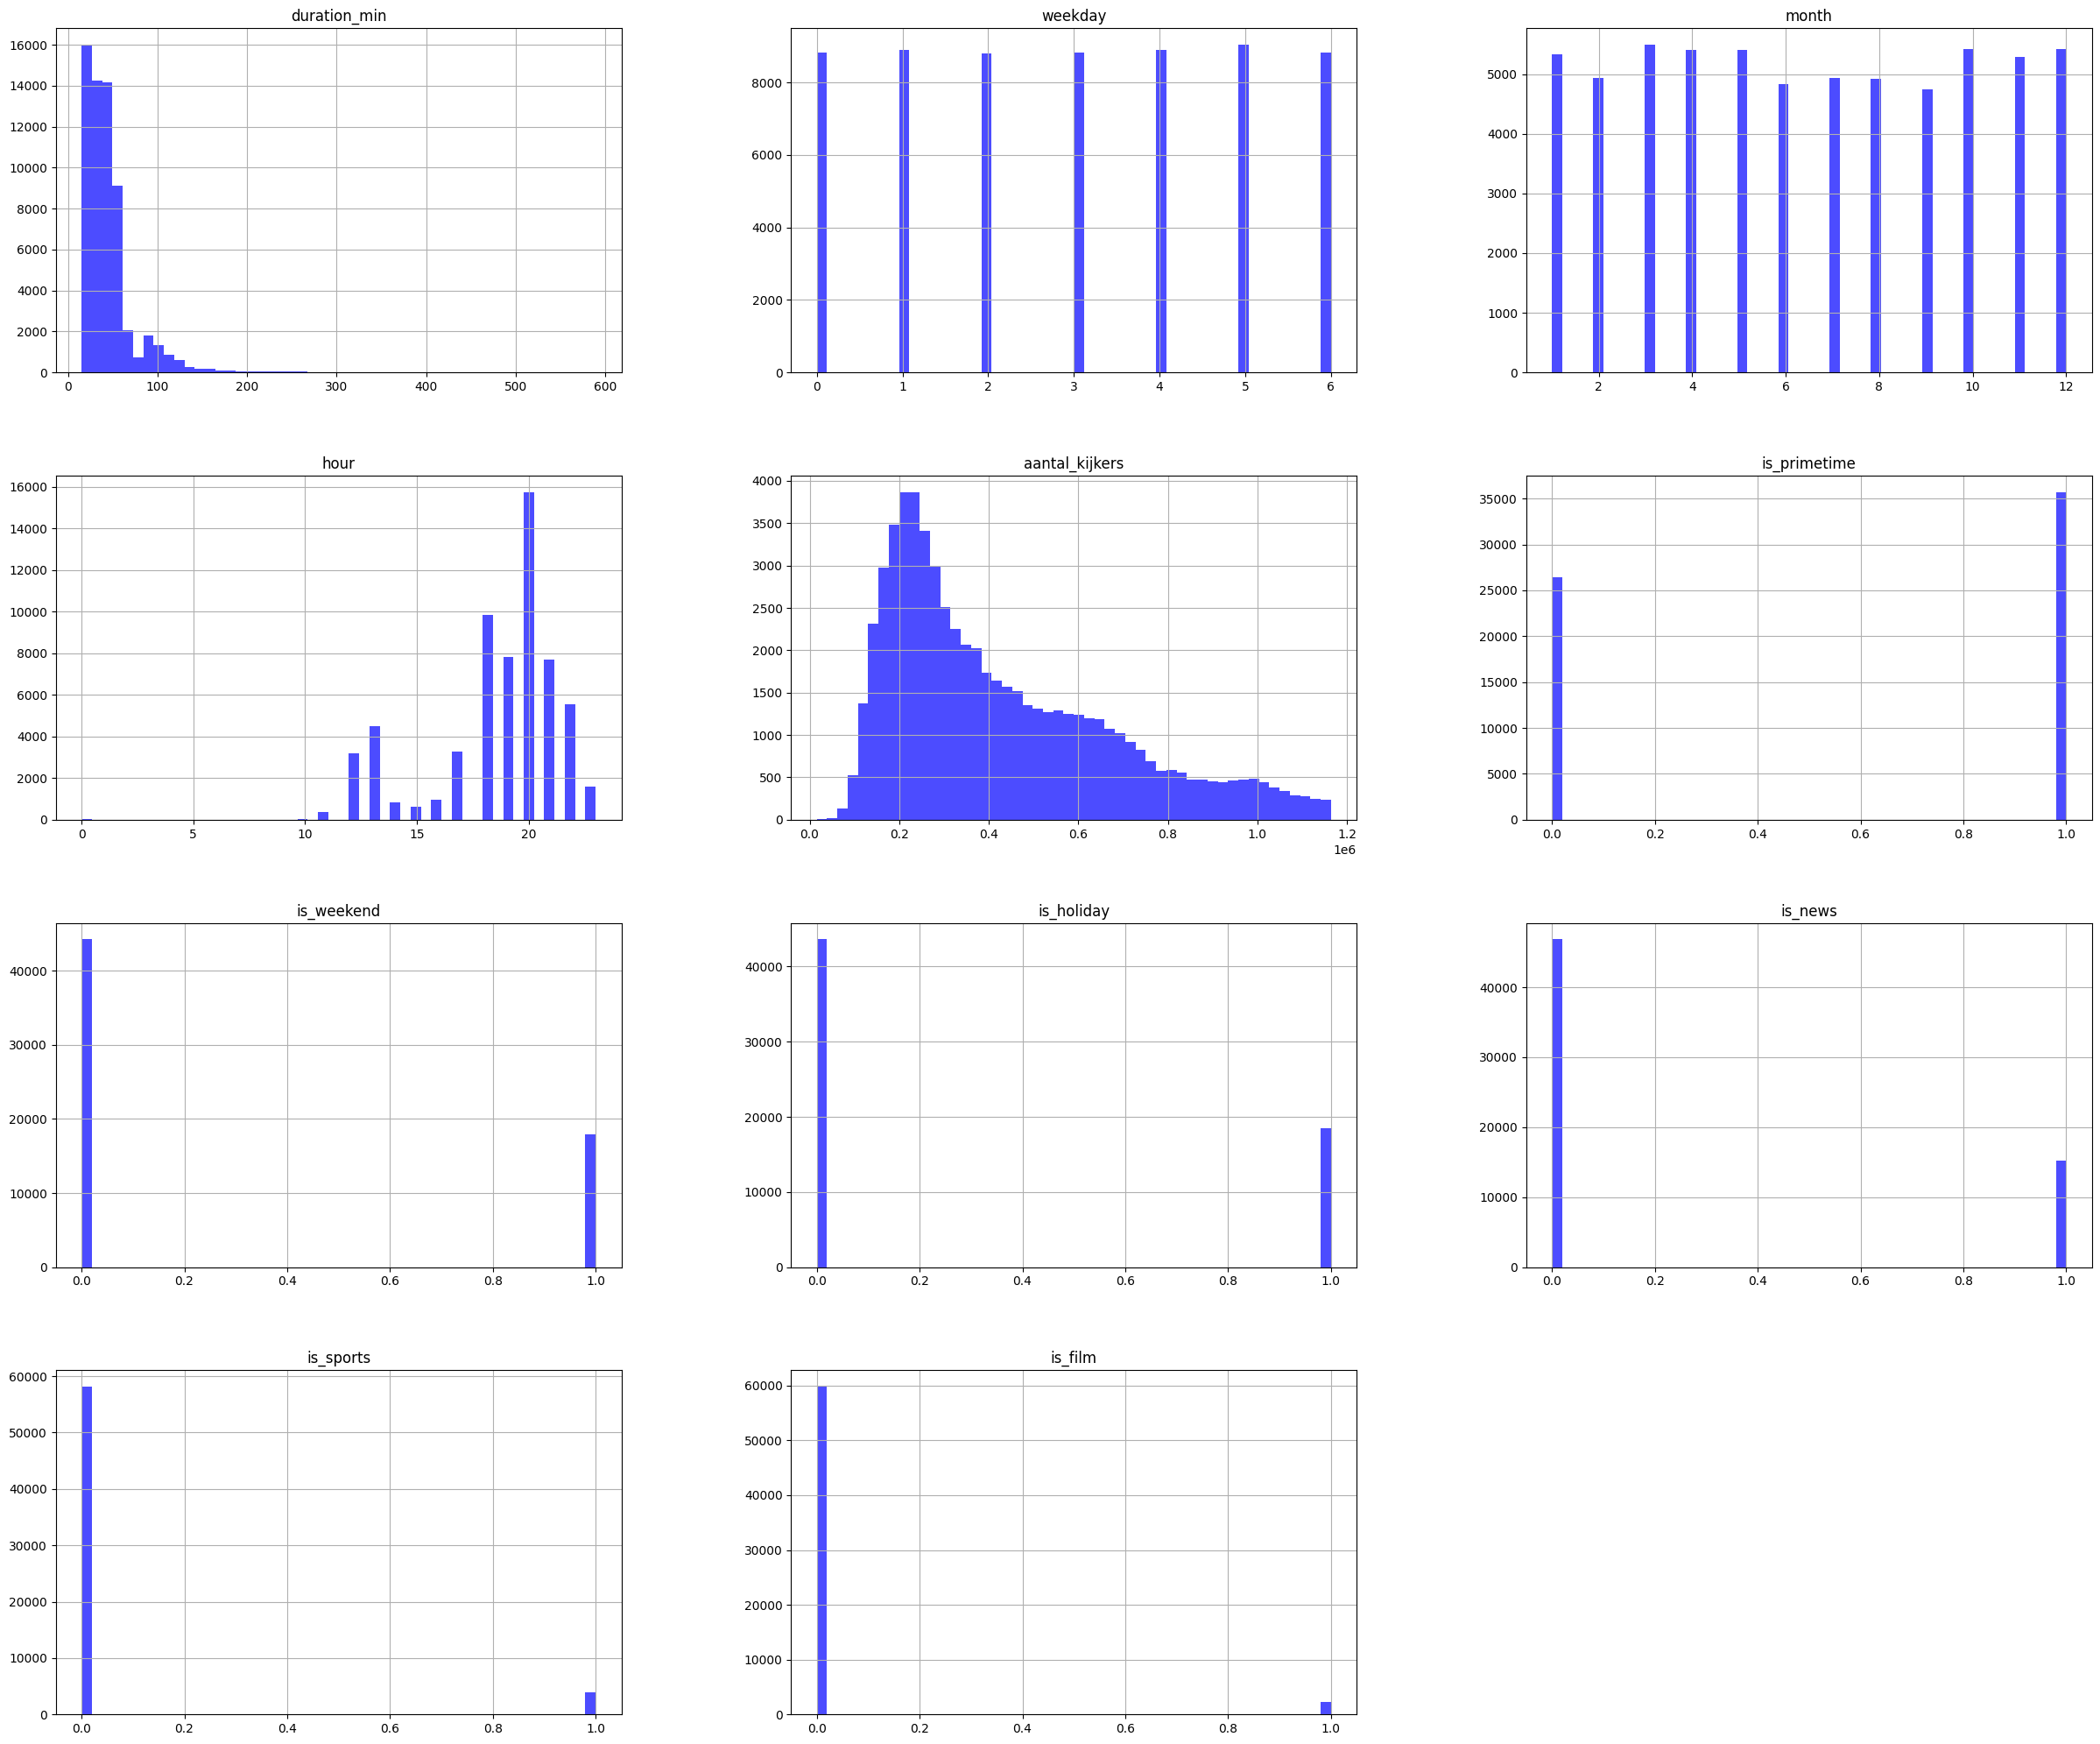

In [ ]:
df_final_no_outliers_kijkcijfers.hist(bins=50, figsize=(30,25), color='blue', alpha=0.7)



In [ ]:

# Outlier-detectie met de IQR-methode
Q1 = df_final_no_outliers_kijkcijfers['duration_min'].quantile(0.25)
Q3 = df_final_no_outliers_kijkcijfers['duration_min'].quantile(0.75)
IQR = Q3 - Q1

# Definieer outliers als waarden buiten 1.5 * IQR van Q1 en Q3
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_final_no_outliers_kijkcijfers[df_final_no_outliers_kijkcijfers['duration_min'] > upper_bound]
print(f"Aantal outliers: {len(outliers)}")
print(outliers[['description', 'channel', 'duration_min']].sort_values('duration_min', ascending=False).head(10))



Aantal outliers: 5365
                                description           channel  duration_min
56478                                KIES24             VRT 1        589.32
14830                             STEM 2018               VTM        567.65
19306                                KIES19               EEN        566.43
14826                                KIES18               EEN        559.92
58998                                KIES24             VRT 1        543.73
59001                             STEM 2024               VTM        502.98
56482       STEM24 DE GROTE VERKIEZINGSSHOW               VTM        482.43
43313                EUROPEAN CHAMPIONSHIPS            Canvas        481.58
44028  WIELRENNEN. WK. WEGRIT WOLLONGONG H.               EEN        423.45
33840                   CYCL. GIRO D'ITALIA  EUROSPORT 1 (NL)        373.62


In [ ]:
df_final_no_outliers_kijkcijfers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62102 entries, 0 to 63397
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   description      62102 non-null  object 
 1   channel          62102 non-null  object 
 2   startTime_fixed  62102 non-null  object 
 3   duration_min     62102 non-null  float64
 4   weekday          62102 non-null  int32  
 5   month            62102 non-null  int32  
 6   hour             62096 non-null  float64
 7   aantal_kijkers   62102 non-null  Int64  
 8   is_primetime     62102 non-null  int64  
 9   is_weekend       62102 non-null  int64  
 10  is_holiday       62102 non-null  int64  
 11  is_news          62102 non-null  int64  
 12  is_sports        62102 non-null  int64  
 13  is_film          62102 non-null  int64  
dtypes: Int64(1), float64(2), int32(2), int64(6), object(3)
memory usage: 6.7+ MB


In [ ]:
df_final_no_outliers_kijkcijfers = df_final_no_outliers_kijkcijfers[df_final_no_outliers_kijkcijfers['hour'].notnull()]

df_final_no_outliers_kijkcijfers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62096 entries, 0 to 63397
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   description      62096 non-null  object 
 1   channel          62096 non-null  object 
 2   startTime_fixed  62096 non-null  object 
 3   duration_min     62096 non-null  float64
 4   weekday          62096 non-null  int32  
 5   month            62096 non-null  int32  
 6   hour             62096 non-null  float64
 7   aantal_kijkers   62096 non-null  Int64  
 8   is_primetime     62096 non-null  int64  
 9   is_weekend       62096 non-null  int64  
 10  is_holiday       62096 non-null  int64  
 11  is_news          62096 non-null  int64  
 12  is_sports        62096 non-null  int64  
 13  is_film          62096 non-null  int64  
dtypes: Int64(1), float64(2), int32(2), int64(6), object(3)
memory usage: 6.7+ MB


In [ ]:
kijkcijfers_final = df_final_no_outliers_kijkcijfers.copy()
# Sla de uiteindelijke DataFrame op als CSV
kijkcijfers_final.to_csv('./Data/CleanData/kijkcijfers_final.csv', index=False, encoding='utf-8')
# Toon de eerste paar rijen van de uiteindelijke DataFrame  
print(kijkcijfers_final.head())

          description channel startTime_fixed  duration_min  weekday  month  \
0    IEDEREEN BEROEMD     EEN        19:38:10         29.02        5     10   
1      COMEDY TOPPERS     VTM        19:52:06         24.67        5     10   
2        THE FUGITIVE     EEN        21:22:25        121.42        5     10   
3      NIEUWS 19U VTM     VTM        18:59:49         42.45        5     10   
4  HET 1 UUR-JOURNAAL     EEN        13:00:05         22.80        5     10   

   hour  aantal_kijkers  is_primetime  is_weekend  is_holiday  is_news  \
0  19.0          523610             1           1           0        0   
1  19.0          496216             1           1           0        0   
2  21.0          447427             1           1           0        0   
3  18.0          424041             1           1           0        1   
4  13.0          369066             0           1           0        1   

   is_sports  is_film  
0          0        0  
1          0        0  
2       

## prepare 4 ML


In [5]:
import numpy as np
import sklearn as sk

X = df.drop(columns=['aantal_kijkers'])
y = df['aantal_kijkers']

np.random.seed(42)  

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


onehot_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

standardize_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])



In [7]:
from sklearn.compose import ColumnTransformer

preprocessing = ColumnTransformer(transformers=[
    ('num', standardize_pipeline, ['minutes_since_midnight', 'duration_min', 'hour']),
    ('cat', onehot_pipeline, ['channel'])
], remainder='passthrough') 


## Machine learning

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

lin_reg = make_pipeline(preprocessing, LinearRegression())  
lin_reg.fit(X_train, y_train)

from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error
lineair_predictions = lin_reg.predict(X_train)
lin_rmse = root_mean_squared_error(y_train, lineair_predictions)
lin_r2 = r2_score(y_train, lineair_predictions)
lin_mape = mean_absolute_percentage_error(y_train, lineair_predictions)
print(f"Lineaire regressie - RMSE: {lin_rmse:.2f}, R^2: {lin_r2:.2f}, MAPE: {lin_mape:.2%}")


Lineaire regressie - RMSE: 172307.12, R^2: 0.53, MAPE: 41.31%


In [9]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = make_pipeline(preprocessing, PolynomialFeatures(degree=2), LinearRegression())
poly_features.fit(X_train, y_train)
poly_predictions = poly_features.predict(X_train)
poly_rmse = root_mean_squared_error(y_train, poly_predictions)
poly_r2 = r2_score(y_train, poly_predictions)
poly_mape = mean_absolute_percentage_error(y_train, poly_predictions)
print(f"Polynomiale regressie - RMSE: {poly_rmse:.2f}, R^2: {poly_r2:.2f}, MAPE: {poly_mape:.2%}")

Polynomiale regressie - RMSE: 143526.29, R^2: 0.67, MAPE: 30.40%


In [10]:
from sklearn.svm import LinearSVR

svm_model_lin = make_pipeline(preprocessing, LinearSVR(epsilon=1.5, random_state=42))
svm_model_lin.fit(X_train, y_train)
svm_predictions = svm_model_lin.predict(X_train)
svm_rmse = root_mean_squared_error(y_train, svm_predictions)
svm_r2 = r2_score(y_train, svm_predictions)
svm_mape = mean_absolute_percentage_error(y_train, svm_predictions)
print(f"SVM - RMSE: {svm_rmse:.2f}, R^2: {svm_r2:.2f}, MAPE: {svm_mape:.2%}")

SVM - RMSE: 312296.19, R^2: -0.54, MAPE: 55.82%


In [11]:
from sklearn.svm import LinearSVR

svm_model_poly = make_pipeline(preprocessing, LinearSVR(random_state=42))
svm_model_poly.fit(X_train, y_train)
svm_poly_predictions = svm_model_poly.predict(X_train)
svm_poly_rmse = root_mean_squared_error(y_train, svm_poly_predictions)
svm_poly_r2 = r2_score(y_train, svm_poly_predictions)
svm_poly_mape = mean_absolute_percentage_error(y_train, svm_poly_predictions)
print(f"SVM met polynomiale features - RMSE: {svm_poly_rmse:.2f}, R^2: {svm_poly_r2:.2f}, MAPE: {svm_poly_mape:.2%}")

SVM met polynomiale features - RMSE: 312295.37, R^2: -0.54, MAPE: 55.82%


In [12]:
from sklearn.tree import DecisionTreeRegressor
tree_model3 = make_pipeline(preprocessing,DecisionTreeRegressor(max_depth=3,random_state=42))
tree_model3.fit(X_train, y_train)
tree_predictions = tree_model3.predict(X_train)
tree_rmse = root_mean_squared_error(y_train, tree_predictions)
tree_r2 = r2_score(y_train, tree_predictions)
tree_mape = mean_absolute_percentage_error(y_train, tree_predictions)
print(f"Decision Tree - RMSE: {tree_rmse:.2f}, R^2: {tree_r2:.2f}, MAPE: {tree_mape:.2%}")

Decision Tree - RMSE: 179082.70, R^2: 0.49, MAPE: 44.47%


In [13]:
from sklearn.tree import DecisionTreeRegressor
tree_model10 = make_pipeline(preprocessing,DecisionTreeRegressor(min_samples_leaf=10,random_state=42))
tree_model10.fit(X_train, y_train)
tree_predictions = tree_model10.predict(X_train)
tree_rmse = root_mean_squared_error(y_train, tree_predictions)
tree_r2 = r2_score(y_train, tree_predictions)
tree_mape = mean_absolute_percentage_error(y_train, tree_predictions)
print(f"Decision Tree - RMSE: {tree_rmse:.2f}, R^2: {tree_r2:.2f}, MAPE: {tree_mape:.2%}")

Decision Tree - RMSE: 85003.75, R^2: 0.89, MAPE: 17.09%


In [14]:
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.svm import SVR


voting_regressor = make_pipeline(preprocessing,VotingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(random_state=42)),
        ('svr', SVR(kernel='linear', C=1.0, epsilon=0.1)),
        ('tree', DecisionTreeRegressor(max_depth=10, random_state=42))]
))
voting_regressor.fit(X_train, y_train)
voting_predictions = voting_regressor.predict(X_train)
voting_rmse = root_mean_squared_error(y_train, voting_predictions)
voting_r2 = r2_score(y_train, voting_predictions)
voting_mape = mean_absolute_percentage_error(y_train, voting_predictions)
print(f"Voting Regressor - RMSE: {voting_rmse:.2f}, R^2: {voting_r2:.2f}, MAPE: {voting_mape:.2%}")

Voting Regressor - RMSE: 110492.94, R^2: 0.81, MAPE: 24.05%


In [15]:
from sklearn.ensemble import BaggingRegressor
bagging_regressor = make_pipeline(preprocessing, BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=10, random_state=42),
    n_estimators=500,
    random_state=42, bootstrap=True, n_jobs=-1, max_samples=100
))

bagging_regressor.fit(X_train, y_train)
bagging_predictions = bagging_regressor.predict(X_train)
bagging_rmse = root_mean_squared_error(y_train, bagging_predictions)
bagging_r2 = r2_score(y_train, bagging_predictions)
bagging_mape = mean_absolute_percentage_error(y_train, bagging_predictions)
print(f"Bagging Regressor - RMSE: {bagging_rmse:.2f}, R^2: {bagging_r2:.2f}, MAPE: {bagging_mape:.2%}")

Bagging Regressor - RMSE: 146286.87, R^2: 0.66, MAPE: 36.16%


In [16]:
from sklearn.ensemble import RandomForestRegressor

rf_model = make_pipeline(preprocessing, RandomForestRegressor(n_estimators=100, random_state=42))

rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_train)
rf_rmse = root_mean_squared_error(y_train, rf_predictions)
rf_r2 = r2_score(y_train, rf_predictions)
rf_mape = mean_absolute_percentage_error(y_train, rf_predictions)
print(f"Random Forest - RMSE: {rf_rmse:.2f}, R^2: {rf_r2:.2f}, MAPE: {rf_mape:.2%}")

Random Forest - RMSE: 36250.61, R^2: 0.98, MAPE: 7.30%


In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

ada_model = make_pipeline(preprocessing, AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=3, random_state=42),
    n_estimators=100,
    random_state=42
))

ada_model.fit(X_train, y_train)
ada_predictions = ada_model.predict(X_train)
ada_rmse = root_mean_squared_error(y_train, ada_predictions)
ada_r2 = r2_score(y_train, ada_predictions)
ada_mape = mean_absolute_percentage_error(y_train, ada_predictions)
print(f"AdaBoost - RMSE: {ada_rmse:.2f}, R^2: {ada_r2:.2f}, MAPE: {ada_mape:.2%}")

AdaBoost - RMSE: 179625.19, R^2: 0.49, MAPE: 52.71%


In [18]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = make_pipeline(preprocessing, GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    n_iter_no_change=10,
))

gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_train)
gb_rmse = root_mean_squared_error(y_train, gb_predictions)
gb_r2 = r2_score(y_train, gb_predictions)
gb_mape = mean_absolute_percentage_error(y_train, gb_predictions)
print(f"Gradient Boosting - RMSE: {gb_rmse:.2f}, R^2: {gb_r2:.2f}, MAPE: {gb_mape:.2%}")

Gradient Boosting - RMSE: 128307.22, R^2: 0.74, MAPE: 28.43%


In [19]:
from xgboost import XGBRegressor
xgb_model = make_pipeline(preprocessing, XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    n_jobs=-1,
    n_iter_no_change=10,
))

xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_train)
xgb_rmse = root_mean_squared_error(y_train, xgb_predictions)
xgb_r2 = r2_score(y_train, xgb_predictions)
xgb_mape = mean_absolute_percentage_error(y_train, xgb_predictions)
print(f"XGBoost - RMSE: {xgb_rmse:.2f}, R^2: {xgb_r2:.2f}, MAPE: {xgb_mape:.2%}")

c:\Users\nelzon\Documents\DJens\School\Machine Learning\KijkcijfersProject\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:00:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_iter_no_change" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - RMSE: 128440.09, R^2: 0.74, MAPE: 28.43%


In [20]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

stack_clf = make_pipeline(preprocessing, StackingRegressor(
    estimators=[
        ('svr', SVR(kernel='linear', C=1.0, epsilon=0.1)),
        ('tree', DecisionTreeRegressor(max_depth=10, random_state=42))
    ],
    final_estimator=RandomForestRegressor(random_state=42),
    cv=5
))
stack_clf.fit(X_train, y_train)
stack_predictions = stack_clf.predict(X_train)
stack_rmse = root_mean_squared_error(y_train, stack_predictions)
stack_r2 = r2_score(y_train, stack_predictions)
stack_mape = mean_absolute_percentage_error(y_train, stack_predictions)
print(f"Stacking Regressor - RMSE: {stack_rmse:.2f}, R^2: {stack_r2:.2f}, MAPE: {stack_mape:.2%}")

Stacking Regressor - RMSE: 118796.37, R^2: 0.78, MAPE: 25.82%


## Gridsearch op modellen met potentie

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Definieer een functie om grid search uit te voeren en resultaten weer te geven
def run_grid_search(pipeline, param_grid, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    
    print(f"Beste parameters: {grid_search.best_params_}")
    print(f"Beste RMSE (train): {(-grid_search.best_score_)**0.5:.2f}")
    
    # Evalueer op testset
    test_score = (-grid_search.score(X_test, y_test))**0.5
    print(f"RMSE (test): {test_score:.2f}")
    
    return grid_search.best_estimator_

In [22]:
from sklearn.preprocessing import PolynomialFeatures

poly_param_grid = {
    'polynomialfeatures__degree': [1, 2],
    'linearregression__fit_intercept': [True, False]
}

poly_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('polynomialfeatures', PolynomialFeatures()),
    ('linearregression', LinearRegression())
])

best_poly = run_grid_search(poly_pipeline, poly_param_grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Beste parameters: {'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 2}
Beste RMSE (train): 382.89
RMSE (test): 381.60


In [23]:
tree_param_grid = {
    'decisiontreeregressor__max_depth': [10, 20, 25],
    'decisiontreeregressor__min_samples_split': [1, 2, 5],
    'decisiontreeregressor__min_samples_leaf': [5, 10, 12]
}

tree_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('decisiontreeregressor', DecisionTreeRegressor(random_state=42))
])

best_tree = run_grid_search(tree_pipeline, tree_param_grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\nelzon\Documents\DJens\School\Machine Learning\KijkcijfersProject\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\nelzon\Documents\DJens\School\Machine Learning\KijkcijfersProject\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nelzon\Documents\DJens\School\Machine Learning\KijkcijfersProject\.venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper


Beste parameters: {'decisiontreeregressor__max_depth': 25, 'decisiontreeregressor__min_samples_leaf': 12, 'decisiontreeregressor__min_samples_split': 2}
Beste RMSE (train): 326.79
RMSE (test): 323.00


In [24]:
rf_param_grid = {
    'randomforestregressor__n_estimators': [100, 200, 300],
    'randomforestregressor__max_depth': [5, 10, 20, 25],
    'randomforestregressor__min_samples_split': [5, 10, 12],
    'randomforestregressor__min_samples_leaf': [1, 2]
}

rf_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('randomforestregressor', RandomForestRegressor(random_state=42))
])

best_rf = run_grid_search(rf_pipeline, rf_param_grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Beste parameters: {'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__n_estimators': 300}
Beste RMSE (train): 308.83
RMSE (test): 305.40


In [25]:
from sklearn.ensemble import GradientBoostingRegressor

gb_param_grid = {
    'gradientboostingregressor__n_estimators': [100, 200, 300],
    'gradientboostingregressor__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [5, 7, 10],
    'gradientboostingregressor__min_samples_split': [2, 5, 7],
    'gradientboostingregressor__validation_fraction': [0.1],
    'gradientboostingregressor__n_iter_no_change': [5]
}

gb_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('gradientboostingregressor', GradientBoostingRegressor(random_state=42))
])

best_gb = run_grid_search(gb_pipeline, gb_param_grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Beste parameters: {'gradientboostingregressor__learning_rate': 0.05, 'gradientboostingregressor__max_depth': 10, 'gradientboostingregressor__min_samples_split': 7, 'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor__n_iter_no_change': 5, 'gradientboostingregressor__validation_fraction': 0.1}
Beste RMSE (train): 310.59
RMSE (test): 307.57


In [26]:
xgb_param_grid = {
    'xgbregressor__n_estimators': [100, 200, 300],  
    'xgbregressor__learning_rate': [0.05, 0.1, 0.2],  
    'xgbregressor__max_depth': [5, 7, 10], 
    'xgbregressor__subsample': [0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.8], 
    'xgbregressor__gamma': [0], 
    'xgbregressor__reg_alpha': [0],
    'xgbregressor__reg_lambda': [1]
}

xgb_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('xgbregressor', XGBRegressor(random_state=42))
])

best_xgb = run_grid_search(xgb_pipeline, xgb_param_grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Beste parameters: {'xgbregressor__colsample_bytree': 0.8, 'xgbregressor__gamma': 0, 'xgbregressor__learning_rate': 0.05, 'xgbregressor__max_depth': 10, 'xgbregressor__n_estimators': 300, 'xgbregressor__reg_alpha': 0, 'xgbregressor__reg_lambda': 1, 'xgbregressor__subsample': 0.8}
Beste RMSE (train): 307.05
RMSE (test): 302.88


In [28]:
best_models = {
    'Polynomial': best_poly,
    'Decision Tree': best_tree,
    'Random Forest': best_rf,
    'Gradient Boosting': best_gb,
    'XGBoost': best_xgb
}

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"{name} - Test RMSE: {rmse:.2f}, R^2: {r2:.2f}, MAPE: {mape:.2%}")

Polynomial - Test RMSE: 145617.55, R^2: 0.67, MAPE: 30.42%
Decision Tree - Test RMSE: 104329.50, R^2: 0.83, MAPE: 20.72%
Random Forest - Test RMSE: 93269.33, R^2: 0.87, MAPE: 18.83%
Gradient Boosting - Test RMSE: 94597.53, R^2: 0.86, MAPE: 19.35%
XGBoost - Test RMSE: 91736.99, R^2: 0.87, MAPE: 18.77%
